# Twitter Data Wrangling Project  
Tianyue Niu

#### Install & Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import tweepy

# Gather

Gathering Data for this Project
Gather each of the three pieces of data as described below in a Jupyter Notebook titled wrangle_act.ipynb:

**The WeRateDogs Twitter archive: twitter_archive_enhanced.csv**

In [2]:
#WeRateDogs Twitter archive
archive = pd.read_csv('twitter-archive-enhanced.csv')

**The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically from: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv**

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_pred = pd.read_csv(url, sep = '\t')

In [4]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


**Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.**

In [ ]:
#Query Tweitter API for each tweet's JSON data
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [5]:
#Read JSON file
#tweet ID "id_str", retweet count "retweet_count", and favorite count "favorite_count"
data = []
with open('tweet_json.txt') as f:
    for line in f:
        data.append(json.loads(line))

In [6]:
tweet = pd.DataFrame(data)

# Assess & Cleaning

Things we are going to change/clean for the three data sets:
#### Quality

- Quality 1: We only want original tweets, so we need to drop rows with a reply-to id or a retweet id (archive)
- Quality 2: Evaluate entries for 'rating_numerator' and correct if necessary (archive)
- Quality 3: Correct incorrect dog names (change non-names to 'None') (archive)
- Quality 4: Change missing values to "Unknown" for dog names (archive)
- Quality 5: Change timestamp data type to datetime (archive)
- Quality 6: correct hard to read column names (for image predictions data)
- Quality 7: Inconsistent dog type names (for image predictions data)
- Quality 8: Rename id column for future merges (twitter API)

#### Tidiness  

- Tidiness 1: Merge four dog stages into a new 'stage' column (archive)
- Tidiness 2: Merge different data sets together

**1) Archive**
- Quality 1: We only want original tweets, so we need to drop rows with a reply-to id or a retweet id (archive)
- Quality 2: Evaluate entries for 'rating_numerator' and correct if necessary (archive)
- Quality 3: Correct incorrect dog names (change non-names to 'None') (archive)
- Quality 4: Change missing values to "Unknown" for dog names (archive)
- Quality 5: Change timestamp data type to datetime (archive)
- Tidiness 1: Merge four dog stages into a new 'stage' column

*Drop rows with a reply-to-id or a retweet-id*

In [58]:
archive #visuall assess

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [7]:
archive_clean = archive.copy() #create a clean copy with shape (2356, 17)

In [8]:
#only include tweets that do not have an reply_to id or a retweeted_status_id
archive_clean=archive_clean[archive_clean['in_reply_to_status_id'].isnull()] 
archive_clean=archive_clean[archive_clean['retweeted_status_id'].isnull()] 

In [9]:
archive_clean.info() #check if the above operations were performed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

In [10]:
#drop vars because they are no longer useful
vars=['in_reply_to_status_id', 
      'in_reply_to_user_id', 
      'retweeted_status_id', 
      'retweeted_status_user_id',
      'retweeted_status_timestamp']
archive_clean.drop(vars, axis=1, inplace=True)

*Clean numerator & denominator*

In [11]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


In [12]:
#cleaning rating_numerator and rating denominator
print("There are", archive_clean[archive_clean['rating_denominator']>10]['rating_denominator'].count(), "dogs with rating denominator >10")

There are 15 dogs with rating denominator >10


In [13]:
archive_clean[archive_clean['rating_denominator']>10] #15

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
902,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1274,709198395643068416,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None
1351,704054845121142784,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None


In [14]:
#some interesting mistakes were made here
#in some tweets, another fraction appears before the actual rating, and that fraction is mistakenly taken 
#as the rating.
#I manually opened some odd-looking ratings:
    #index 1068: actually got a rating of 14/10, however 9/11 was in the text so 9 out of 11 was recorded as its rating
    #index 1165: should get 13/10 instead of 4/20 (a date)
    #index 1202: should get 11/10 instead of 50/50 (fifty:fifty)
    #index 1662: should get 10/10 insetad of 7/11 (seven-eleven)
#I didn't manually check all 15 due to time constraint. But let's change the above four to the correct score:

In [15]:
archive_clean.loc[1068, 'rating_numerator'] = 14 
archive_clean.loc[1068, 'rating_denominator'] = 10
archive_clean.loc[1165, 'rating_numerator'] = 13 
archive_clean.loc[1165, 'rating_denominator'] = 10 
archive_clean.loc[1202, 'rating_numerator'] = 11 
archive_clean.loc[1202, 'rating_denominator'] = 10 
archive_clean.loc[1662, 'rating_numerator'] = 10
archive_clean.loc[1662, 'rating_denominator'] = 10

In [16]:
#test
labels=[1068,1165,1202,1662]
archive_clean.loc[labels][['rating_denominator','rating_numerator']]

,rating_denominator,rating_numerator
1068,10,14
1165,10,13
1202,10,11
1662,10,10


*Assesing & Cleaning Dog Names*

In [17]:
archive_clean['name'].value_counts().head(5)
#there are several strange words entered as name
#all of them starts with lower letters, so we'll change all names starting with lower letters to None

None       603
a           55
Charlie     11
Lucy        11
Cooper      10
Name: name, dtype: int64

In [18]:
lst=archive_clean[archive_clean.name.str.islower()]['name'].tolist()

In [19]:
archive_clean.name.replace(lst, 'Unknown', inplace=True) #replace names in list with 'Unknown'

In [20]:
archive_clean.name.replace('None', 'Unknown', inplace=True) #change all "None" to "Unknown"

In [21]:
archive_clean.name.isin(lst).value_counts() #check if we've changed them correctly

False    2097
Name: name, dtype: int64

*Change timestamp to date*

In [22]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

In [23]:
archive_clean['timestamp'].head(2) #check if it was converted correctly

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

*Create stage as a new variable and drop the four stage columns*

In [24]:
archive_clean.doggo.replace('None', '', inplace=True) 
archive_clean.floofer.replace('None', '', inplace=True) 
archive_clean.pupper.replace('None', '', inplace=True) 
archive_clean.puppo.replace('None', '', inplace=True)
archive_clean['stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

In [25]:
archive_clean.stage.replace('', 'Unknown', inplace=True)

In [26]:
archive_clean.stage.value_counts()

Unknown         1761
pupper           221
doggo             72
puppo             23
floofer            9
doggopupper        9
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

In [27]:
archive_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True) #drop the four columns

In [52]:
archive_clean.loc[archive_clean.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
archive_clean.loc[archive_clean.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'
archive_clean.loc[archive_clean.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'

In [ ]:
#test

In [54]:
archive_clean.stage.value_counts()

Unknown           1761
pupper             221
doggo               72
puppo               23
floofer              9
doggo, pupper        9
doggo, puppo         1
doggo, floofer       1
Name: stage, dtype: int64

**2) Image prediciton** 
- Quality 6: Change hard to read column names to more interpretable ones  
- Quality 7: Correct inconsistent dog type names

*Change hard to read column names to more interpretable ones*

In [57]:
image_pred #visually assess

,tweet_id,jpg_url,img_num,prediction_1,p1_confidence,p1_dog,prediction_2,p2_confidence,p2_dog,prediction_3,p3_confidence,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,bernese_mountain_dog,0.651137,True,english_springer,0.263788,True,greater_swiss_mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [29]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [30]:
image_pred.rename(columns={"p1": "prediction_1", "p1_conf": "p1_confidence",
                           "p2": "prediction_2", "p2_conf": "p2_confidence",
                           "p3": "prediction_3", "p3_conf": "p3_confidence"}, inplace=True)

*Correct inconsistent dog type format*

In [31]:
#change all to lowered letters
image_pred.prediction_1=image_pred.prediction_1.str.lower() 
image_pred.prediction_2=image_pred.prediction_2.str.lower()
image_pred.prediction_3=image_pred.prediction_3.str.lower()

In [32]:
image_pred.prediction_1.value_counts().head(5)

golden_retriever      150
labrador_retriever    100
pembroke               89
chihuahua              83
pug                    57
Name: prediction_1, dtype: int64

**3) Tweet**
- Quality 8: Rename id column for future merges

*Rename id column*

In [56]:
tweet

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [33]:
tweet = tweet[['id','retweet_count', 'favorite_count']] #we are only interested in these three columns

In [34]:
tweet.rename(columns={'id': 'tweet_id'}, inplace=True)

In [35]:
tweet.query('retweet_count>10000').count()

tweet_id          138
retweet_count     138
favorite_count    138
dtype: int64

#### Lastly: merge dataset together

- Tidiness 2: Merging Data Together using 'tweet_id' as key

In [36]:
twitter_total = pd.merge(archive_clean, image_pred, on='tweet_id', how='inner')

In [37]:
tweet_final=pd.merge(twitter_total, tweet, on='tweet_id')

In [38]:
tweet_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns, UTC]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
stage                 1971 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null int64
prediction_1          1971 non-null object
p1_confidence         1971 non-null float64
p1_dog                1971 non-null bool
prediction_2          1971 non-null object
p2_confidence         1971 non-null float64
p2_dog                1971 non-null bool
prediction_3          1971 non-null object
p3_confidence         1971 non-null float64
p3_dog                1971 non-null bool
retweet_count         1971 

# Basic Analysis & Visualization

three (3) insights and one (1) visualization 

In [39]:
tweet_final.shape

(1971, 22)

In [40]:
tweet_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns, UTC]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
stage                 1971 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null int64
prediction_1          1971 non-null object
p1_confidence         1971 non-null float64
p1_dog                1971 non-null bool
prediction_2          1971 non-null object
p2_confidence         1971 non-null float64
p2_dog                1971 non-null bool
prediction_3          1971 non-null object
p3_confidence         1971 non-null float64
p3_dog                1971 non-null bool
retweet_count         1971 

In [41]:
import matplotlib.pyplot as plt

In [42]:
#what are some most frequent predictions that computers made
print(tweet_final['prediction_1'].value_counts().head(5), "\n") 
print(tweet_final['prediction_2'].value_counts().head(5), "\n")
print(tweet_final['prediction_3'].value_counts().head(5), "\n")

golden_retriever      137
labrador_retriever     94
pembroke               88
chihuahua              78
pug                    54
Name: prediction_1, dtype: int64 

labrador_retriever          95
golden_retriever            82
cardigan                    73
chihuahua                   43
chesapeake_bay_retriever    40
Name: prediction_2, dtype: int64 

labrador_retriever    76
chihuahua             57
golden_retriever      45
eskimo_dog            36
kelpie                33
Name: prediction_3, dtype: int64 



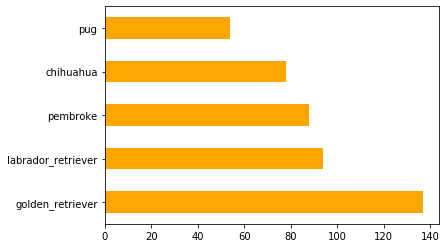

In [43]:
tweet_final['prediction_1'].value_counts().head(5).plot(kind='barh',color='orange')
#tweet_final['prediction_2'].value_counts().head(5).plot(kind='barh',color='coral')
#tweet_final['prediction_3'].value_counts().head(5).plot(kind='barh', color='lightcoral')

For any dog, it is most likely to be predicted as a golden_retriever or a labrador_retriever by the neural network in the first prediction. My guess is that this is because golden retrievers and labradors are what the neural work model has bee trained on the most, so the model is more likely to predict a dog to be a retriever than other breeds.

In [44]:
tweet_final['p1_dog'].value_counts() #1463, #508
tweet_final['p2_dog'].value_counts() #1463 #491
tweet_final['p3_dog'].value_counts() #1431, #54

True     1431
False     540
Name: p3_dog, dtype: int64

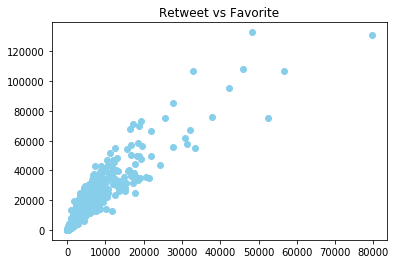

In [45]:
x=tweet_final['retweet_count']
y=tweet_final['favorite_count']
plt.scatter(x,y, color='skyblue')
plt.title("Retweet vs Favorite")
plt.show()
#we see a positive correlation between retweet & favorite, which is unsurprising

The above scatterplot shows retweet_counts (x_axis) is positively correlated with favorite_counts. This intuitively make sense because I’m more likely to retweet something that I like. 


In [46]:
tweet_final[tweet_final['rating_numerator']==1776]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,...,p1_confidence,p1_dog,prediction_2,p2_confidence,p2_dog,prediction_3,p3_confidence,p3_dog,retweet_count,favorite_count
722,749981277374128128,2016-07-04 15:00:45+00:00,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,Unknown,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,...,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,2772,5569


In [47]:
small=tweet_final.query('rating_numerator < 100')

In [48]:
small['stage'].value_counts()

Unknown         1662
pupper           201
doggo             63
puppo             22
doggopupper        8
floofer            7
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

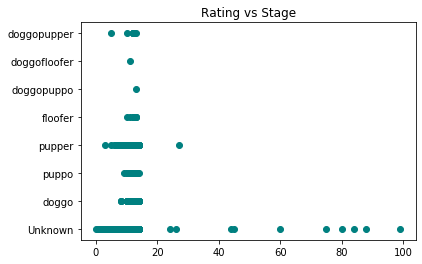

In [49]:
x=small['rating_numerator']
y=small['stage']
plt.scatter(x,y, color='teal')
plt.title("Rating vs Stage")
plt.show()

The above graph only shows dogs with ratings lower or equal to 100 out of 10. We can’t see a clear trend on what dogs are liked the most, since 1662 out of 1971 of our data do not have an entry for dog stage. However, given our limited data, we see that upper seems to be  the most posted stage with ratings among all existing dog stages, and it also tend to have higher votes.

In [51]:
#### Saving final data to csv
tweet_final.to_csv('tweet_final.csv')